In [124]:
import pandas as pd
import torch
import torch.nn as nn
import cv2
import time
import copy
import glob
import matplotlib.pyplot as plt
import os

from PIL import Image
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import classification_report, confusion_matrix

### "EDA"

In [67]:
print("classes: ", glob.glob('train/*'))

for class_ in glob.glob('train/*'):
    print("Number of samples in class {}: {}".format(class_, len(glob.glob(class_+'/*'))))

classes:  ['train\\0', 'train\\1', 'train\\2', 'train\\3', 'train\\4', 'train\\5']
Number of samples in class train\0: 2175
Number of samples in class train\1: 2257
Number of samples in class train\2: 2404
Number of samples in class train\3: 2498
Number of samples in class train\4: 2257
Number of samples in class train\5: 2362


so it's balanced, thank god

In [116]:
print("classes: ", glob.glob('test/*'))

for class_ in glob.glob('test/*'):
    print("Number of samples in class {}: {}".format(class_, len(glob.glob(class_+'/*'))))

classes:  ['test\\0', 'test\\1', 'test\\2', 'test\\3', 'test\\4', 'test\\5']
Number of samples in class test\0: 437
Number of samples in class test\1: 474
Number of samples in class test\2: 553
Number of samples in class test\3: 525
Number of samples in class test\4: 510
Number of samples in class test\5: 501


In [118]:
n_class = 6

check overlap between train and test set

In [120]:
unique_train_img = []
unique_test_img = []

for i in range(n_class):
    unique_train_img += glob.glob(os.path.join('train', str(i), '*'))
    unique_test_img += glob.glob(os.path.join('test', str(i), '*'))

print("overlap between train and test: ", len(set(unique_train_img).intersection(set(unique_test_img))))

overlap between train and test:  0


great

Taking a look at the images, it's quite an intersting feat for class 2 and 3, they are pretty similar structurally (both pictures of mountains/hills). They differ in color, probably means a black and white classification will not do the job

class 0 and class 5, even though their labels are distinct, are actually very similar. Both are street photos, 0 is primarily about buildings and 5 about streets. Because of their structual similarity, I would expect the model to be quite bad at distinguishing the 2 classes


### Define dataset

In [42]:
input_size = (224, 224)
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

train_set = ImageFolder('train', transform=transform)
test_set = ImageFolder('test', transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


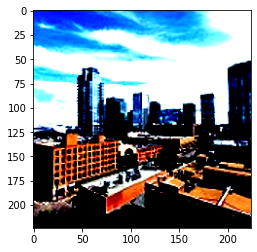

In [45]:
plt.imshow(train_set[1][0].permute(1, 2, 0).numpy())


### Define model

In [99]:
def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# using pretrained vgg 16 model
# it was trained on image net? i believe
model_ft = vgg16(pretrained=True)
set_parameter_requires_grad(model_ft, True)
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs,n_class)

In [100]:
batch_size = 64
device = 'cuda:0'
epochs = 2 # similarity of imagenet with our dataset means not much extra finetuning is needed
lr = .0001 # given that vgg16 has converged, low lr is ok
weight_decay=.01

model_ft = model_ft.to(device)

objective = nn.CrossEntropyLoss() # multiclass problem
optimizer = torch.optim.AdamW(model_ft.parameters(), lr, weight_decay=weight_decay) # adam usually is a good choice
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

### train

In [101]:
iter_ = 0
eval_every = 10

for epoch in range(epochs):
    for batch in train_loader:
        model_ft.zero_grad()
        X, y = batch
        X, y = X.to(device), y.to(device)
        logits = model_ft(X)
        train_loss = objective(logits, y)
        
        train_loss.backward()
        optimizer.step()
        
        if iter_ % eval_every == 0:
            train_acc = (logits.argmax(1)==y).sum() / len(y) # this is an ok metric to use since our dataset is balanced

            # evaluate on test
            with torch.no_grad():
                batch = next(iter(test_loader))
                X, y = batch
                X, y = X.to(device), y.to(device)
                logits = model_ft(X)
                test_loss = objective(logits, y)
                test_acc = (logits.argmax(1)==y).sum() / len(y)

            print("Train (loss, acc): ({}, {}), Test (loss, acc): ({}, {})".format(train_loss.item(), train_acc.item(), test_loss.item(), test_acc.item()))
        iter_ += 1

Train (loss, acc): (1.7927069664001465, 0.234375), Test (loss, acc): (1.8102080821990967, 0.234375)
Train (loss, acc): (1.6239162683486938, 0.375), Test (loss, acc): (1.544893503189087, 0.40625)
Train (loss, acc): (1.3030275106430054, 0.640625), Test (loss, acc): (1.3263347148895264, 0.578125)
Train (loss, acc): (1.08805513381958, 0.71875), Test (loss, acc): (1.152101993560791, 0.640625)
Train (loss, acc): (0.9657379984855652, 0.828125), Test (loss, acc): (0.9900266528129578, 0.75)
Train (loss, acc): (0.821417510509491, 0.84375), Test (loss, acc): (0.8302581310272217, 0.84375)
Train (loss, acc): (0.8351594805717468, 0.8125), Test (loss, acc): (0.7642788290977478, 0.796875)
Train (loss, acc): (0.7820519804954529, 0.828125), Test (loss, acc): (0.7801750898361206, 0.71875)
Train (loss, acc): (0.6792001724243164, 0.859375), Test (loss, acc): (0.634050726890564, 0.875)
Train (loss, acc): (0.7042663097381592, 0.828125), Test (loss, acc): (0.7155942320823669, 0.75)
Train (loss, acc): (0.66185

KeyboardInterrupt: 

### Eval on test set

In [121]:
pred = []
ground = []

with torch.no_grad():
    for batch in test_loader:
        X, y = batch
        X, y = X.to(device), y.to(device)
        logits = model_ft(X)
        pred += logits.argmax(1).cpu().detach().numpy().tolist()
        ground += y.cpu().numpy().tolist()

In [123]:
print(classification_report(ground, pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       437
           1       0.98      1.00      0.99       474
           2       0.80      0.76      0.78       553
           3       0.80      0.78      0.79       525
           4       0.91      0.98      0.94       510
           5       0.90      0.90      0.90       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



In [125]:
confusion_matrix(ground, pred)

array([[387,   1,   0,   2,   1,  46],
       [  0, 473,   1,   0,   0,   0],
       [  0,   2, 420,  93,  35,   3],
       [  0,   2,  99, 411,  11,   2],
       [  4,   0,   5,   3, 498,   0],
       [ 42,   3,   2,   2,   2, 450]], dtype=int64)

^ as expected

### Predict

In [73]:
submission = pd.read_csv('submission.csv')

In [102]:
def load_image(path):
    img = Image.open(path)
    img = transform(img)
    return img

labels = {}
for img in glob.glob('pred/*'):
    file = os.path.split(img)[-1]
    img = load_image(img)
    labels[file] = model_ft(img.unsqueeze(0).to(device)).argmax(1).item()

In [111]:
# pred folder only has 81 images but submission has 100, 
# quick folder lookup finds the remaining images in train/ test folder..
def get_label_from_train_test(file):
    for i in range(n_class):
        if os.path.exists(os.path.join('train', str(i), file)):
            return i
        elif os.path.exists(os.path.join('test', str(i), file)):
            return i
    else:
        return labels[file]

In [115]:
''.join([str(i) for i in submission['File'].apply(get_label_from_train_test).tolist()])

'4011424512040152255244014554113402020043555342144333400253022105135035521225052224551332223522145425'

### Things i would do if this was a real problem
1. check labels credibility (some images could have been mistakenly put into a folder whose class it does not belong to)
2. error analysis on images that were not correctly classified. Potentially train a model with heavier weight on erronous examples. 
3. depending on what system this model is built for, use some sort of interpretability module to explain the prediction
4. augmentation to increase data size (although i don't think gain will be significant)